In [2]:
import pandas as pd

gpx = pd.read_csv('csv\ll_justdiggit_vehicles.csv', parse_dates=['deviceTime'])
gpx.rename(columns={'deviceTime': 'Date', 'lat': 'Latitude', 'lng': 'Longitude', 'tracker_id': 'CodeRoute', 'altitude': 'Altitude', 'speed': 'Speed'}, inplace=True)
# calculate time difference
gpx['TimeDifference'] = (gpx.Date - gpx.Date.shift(1)).dt.seconds
gpx['TimeDifference'] = gpx['TimeDifference'].fillna(0)
# shift lat/lon for distance calculation
gpx['oLatitude'] = gpx['Latitude'].shift(1)
gpx.at[0, 'oLatitude'] = gpx.loc[0, 'Latitude']
gpx['oLongitude'] = gpx['Longitude'].shift(1)
gpx.at[0, 'oLongitude'] = gpx.loc[0, 'Longitude']

gpx = gpx.sort_values(by=['CodeRoute', 'Date'])
gpx['Filename'] = ''

from geopy.distance import geodesic

def distance(row):
    return geodesic((row['oLatitude'], row['oLongitude']), (row['Latitude'], row['Longitude'])).meters

gpx['Distance'] = gpx.apply(distance, axis=1)
gpx.drop(columns=['created_at', 'oLatitude', 'oLongitude', 'id'], inplace=True)
gpx.to_csv('csv\gpx.csv')
gpx.head(25)

CodeRoute  Latitude  Longitude                Date  Altitude     Speed  \
0        1172 -6.193400  35.742725 2019-06-06 08:14:41         0  0.000000   
3        1172 -6.193311  35.742843 2019-06-06 08:14:41        99  0.329968   
4        1172 -6.193311  35.742843 2019-06-06 08:15:30        99  0.329968   
5        1172 -6.193472  35.742803 2019-06-06 08:15:38         4  1.659990   
6        1172 -6.193417  35.742768 2019-06-06 08:16:05         1  1.729970   
7        1172 -6.193357  35.742578 2019-06-06 08:16:37         1  0.300000   
8        1172 -6.193428  35.742712 2019-06-06 08:17:37         1  0.700000   
9        1172 -6.193436  35.742725 2019-06-06 08:17:39         1  1.269980   
10       1172 -6.193400  35.742725 2019-06-06 08:18:36         0  0.300000   
11       1172 -6.193067  35.742603 2019-06-07 05:37:11         1  0.379968   
12       1172 -6.193304  35.742700 2019-06-07 05:38:11         0  0.079968   
13       1172 -6.193344  35.742717 2019-06-07 05:39:11         1  0.169978   
14       1172 -6.193352  35.742795 2019-06-07 05:39:57         0  0.109989   
15       1172 -6.193317  35.742812 2019-06-07 05:40:10         0  0.829968   
16       1172 -6.193351  35.742738 2019-06-07 05:41:10         1  0.109989   
17       1172 -6.193306  35.742735 2019-06-07 05:42:09         0  0.219978   
18       1172 -6.193306  35.742715 2019-06-07 05:42:56         1  0.339957   
19       1172 -6.193304  35.742785 2019-06-07 05:43:09         0  0.289957   
20       1172 -6.193303  35.742802 2019-06-07 05:44:08         0  0.109989   
21       1172 -6.193324  35.742712 2019-06-07 05:45:08         1  0.850000   
22       1172 -6.193442  35.742657 2019-06-07 05:45:55         1  0.389957   
23       1172 -6.193305  35.742723 2019-06-07 05:46:08         1  1.779970   
24       1172 -6.193403  35.742693 2019-06-07 05:47:07         0  0.609989   
25       1172 -6.193371  35.742625 2019-06-07 05:48:07         0  0.129968   
26       1172 -6.193370  35.742650 2019-06-07 05:48:53         1  0.529968   

    TimeDifference Filename   Distance  
0              0.0            0.000000  
3              0.0           41.592752  
4             49.0            0.000000  
5              8.0           18.346651  
6             27.0            7.211036  
7             32.0           22.050085  
8             60.0           16.780573  
9              2.0            1.689002  
10            57.0            3.981139  
11         76715.0           39.222834  
12            60.0           28.322588  
13            60.0            4.806988  
14            46.0            8.677794  
15            13.0            4.303610  
16            60.0            9.011743  
17            59.0            4.987488  
18            47.0            2.213482  
19            13.0            7.750343  
20            59.0            1.884707  
21            60.0           10.227812  
22            47.0           14.399182  
23            13.0           16.819381  
24            59.0           11.334737  
25            60.0            8.316325  
26            46.0            2.769061

In [3]:
import trackanimation
from trackanimation.animation import AnimationTrack

input_directory = "csv\gpx.csv"
dodoma_trk = trackanimation.read_track(input_directory)
dodoma_trk = dodoma_trk.time_video_normalize(time=10, framerate=10)

Groups: 100%|██████████| 3/3 [00:08<00:00,  2.97s/it]


In [4]:
fig = AnimationTrack(df_points=dodoma_trk, dpi=300, bg_map=False)
fig.make_video(output_file='map-test', framerate=5, linewidth=1.0)

FileNotFoundError: [WinError 2] The system cannot find the file specified

In [13]:
import geopandas as gpd
import pandas as pd

%matplotlib inline

gpx = pd.read_csv('csv\ll_justdiggit_vehicles.csv', parse_dates=['deviceTime'])
gpx = gpd.GeoDataFrame(gpx, geometry=gpd.points_from_xy(gpx.lng, gpx.lat))
gpx = gpx.sort_values(by=['tracker_id', 'deviceTime'])
for tracker_id in gpx.tracker_id.unique():
    t = gpx[gpx.tracker_id == tracker_id]
    t = t[t.speed > 0]
    t['enddate'] = gpx.deviceTime.max()
    t['enddate'] = t['enddate'].astype(str)
    t['deviceTime'] = t['deviceTime'].astype(str)
    t.drop(columns=['id', 'tracker_id', 'lat', 'lng', 'altitude', 'speed', 'created_at'], inplace=True)
    t.crs = {'init' :'epsg:4326'}
    t.to_file('shapes/trackers/' + str(tracker_id) + '.shp')
    print(t.head(25))

deviceTime                              geometry  \
3   2019-06-06 08:14:41           POINT (35.742843 -6.193311)   
4   2019-06-06 08:15:30           POINT (35.742843 -6.193311)   
5   2019-06-06 08:15:38           POINT (35.742803 -6.193472)   
6   2019-06-06 08:16:05           POINT (35.742768 -6.193417)   
7   2019-06-06 08:16:37           POINT (35.742578 -6.193357)   
8   2019-06-06 08:17:37           POINT (35.742712 -6.193428)   
9   2019-06-06 08:17:39           POINT (35.742725 -6.193436)   
10  2019-06-06 08:18:36             POINT (35.742725 -6.1934)   
11  2019-06-07 05:37:11           POINT (35.742603 -6.193067)   
12  2019-06-07 05:38:11             POINT (35.7427 -6.193304)   
13  2019-06-07 05:39:11  POINT (35.742717 -6.193344000000001)   
14  2019-06-07 05:39:57           POINT (35.742795 -6.193352)   
15  2019-06-07 05:40:10           POINT (35.742812 -6.193317)   
16  2019-06-07 05:41:10           POINT (35.742738 -6.193351)   
17  2019-06-07 05:42:09           POIN

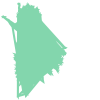

In [11]:
import movingpandas as mpd

traj = mpd.Trajectory(gpx, 1)
traj.to_linestring()

In [12]:
traj.add_speed(overwrite=True)
traj.plot(column="speed", linewidth=5, capstyle='round', legend=True)

AttributeError: 'GeometryArray' object has no attribute 'flags'